## Семинар 9: LSTM [SOLVED]

### Использовался pytorch 0.3.1 

ФИО: Петряйкин Федор Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import sys

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.w_x_f = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_h_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())
        self.b_f   = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.w_x_i = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_h_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())
        self.b_i   = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.w_x_o = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_h_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())
        self.b_o   = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.w_x_c = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_h_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())
        self.b_c   = nn.Parameter(torch.Tensor(hidden_size).normal_())
        
        #Матрица, переводящая скрытые состояния в предсказания
        self.w_h_x = nn.Parameter(torch.Tensor(output_size, hidden_size).normal_())
    
    #Предсказывает сразу последовательность
    def forward(self, X, hidden=None, C=None):
        output = Variable(torch.zeros(X.size(0), self.output_size).cuda())
        if hidden is None:
            hidden = Variable(torch.zeros(self.hidden_size).cuda(), requires_grad=False)
        if C is None:
            C = Variable(torch.zeros(self.hidden_size).cuda(), requires_grad=False)
        
        for t in range(X.size(0)):    
            forget_t = self.sigmoid(torch.mv(self.w_x_f, X[t]) + torch.mv(self.w_h_f, hidden) + self.b_f)
            input_t  = self.sigmoid(torch.mv(self.w_x_i, X[t]) + torch.mv(self.w_h_i, hidden) + self.b_i)
            output_t = self.sigmoid(torch.mv(self.w_x_o, X[t]) + torch.mv(self.w_h_o, hidden) + self.b_o)
            
            C = forget_t*C + input_t*self.tanh(torch.mv(self.w_x_c, X[t]) + torch.mv(self.w_h_c, hidden) + self.b_c)
            
            hidden = output_t.clone() * self.tanh(C)
            output[t] = torch.mv(self.w_h_x, hidden)
        return output, hidden, C

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

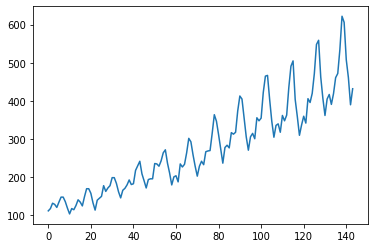

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)

96 48
(96, 1)


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов
def create_shifted(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        dataX.extend(dataset[i : (i+look_back)])
        dataY.extend([dataset[i + look_back]])
    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных
look_back = 1
trainX, trainY = create_shifted(train, look_back)
testX, testY = create_shifted(test, look_back)

*Код обучения*

In [12]:
#Берет данные из dataloader, сам их сдвигает
def TrainModel(model, dataloader, loop_back=1, max_epochs=10000, stop_condition=(5e-7, 50)):
    model.train()
    loss = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=0.1)

    try:
        epochs_losses = []
        for epoch in range(max_epochs):
            losses = []
            for values, _ in dataloader:
                input_vals, output_vals = create_shifted(values.numpy(), loop_back)
                input_var  = Variable(torch.Tensor(input_vals).cuda())
                output_var = Variable(torch.Tensor(output_vals).cuda(), requires_grad=False)
                
                model.zero_grad()
                prediction, h, C = model(input_var)
                loss_batch = loss(prediction, output_var)

                loss_batch.backward()
                optimizer.step()
                losses.append(loss_batch.data.item())

            curr_loss = np.mean(losses)
            epochs_losses.append(curr_loss)
            sys.stdout.write('\r Epoch {0}: mean loss {1}'.format(epoch, curr_loss))

            if epoch > stop_condition[1]:
                if np.mean(np.abs(np.diff(epochs_losses[-stop_condition[1] : ]))) < stop_condition[0]:
                    break
    except KeyboardInterrupt:
        pass

#Возвращает ошибку модели на данных
def GetModelError(model, test_data, look_back=1):
    model.eval()
    test_in, test_out = create_shifted(test_data, look_back)
    
    hidden = None
    C = None
    predictions = []
    for x in test_in:
        input_np = np.array([x])
        input_var = Variable(torch.Tensor(input_np).cuda(), requires_grad=False)
        prediction, hidden, C = model(input_var, hidden, C)
        predictions.append(prediction.cpu().data.numpy()[0])
    
    predictions = np.array(predictions)
    error = np.sqrt(np.mean((predictions - test_out) ** 2))
    return predictions, error

def GetDataloader(dataset, batch_size):
    td = TensorDataset(torch.Tensor(dataset), torch.Tensor(dataset))
    return DataLoader(td, batch_size=batch_size, shuffle=False)

#Делает пример обучения на определенной длине и с определенной длиной скрытого слоя, строит график
#Параметры по умолчанию: обучение на всем, размерность скрытого представления = 5
#Возвращает: модель, предсказание, ошибку
def OutForLength(dataset, train_length=None, hidden_size=5):
    if train_length is None or train_length < 2:
        train_length = dataset.shape[0]
        
    model_curr = LSTM(dataset.shape[1], hidden_size, dataset.shape[1]).cuda()
    dl = GetDataloader(dataset, batch_size=train_length)
    TrainModel(model_curr, dl)
    
    pred, error = GetModelError(model_curr, dataset)
    
    info_str = 'Sequence len = {0}; hidden_size = {1}'.format(train_length, hidden_size)
    print('\n'+info_str)
    print('MSE =', error)
    
    plt.plot(dataset, label='source')
    plt.plot(pred, label='pred')
    plt.axes().legend(loc=0)
    plt.title(info_str)
    plt.show()
    
    return model_curr, pred, error

*Примеры обучений*

1.Различные размерности hidden

 Epoch 702: mean loss 0.0031189683359116316
Sequence len = 144; hidden_size = 5
MSE = 0.05580914


e:\c_folders\sdk\python37\lib\site-packages\ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


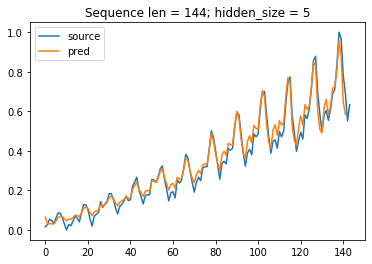

In [13]:
res = OutForLength(dataset, hidden_size=5)

In [ ]:
res = OutForLength(dataset, hidden_size=10)

 Epoch 3251: mean loss 0.0039542508311569695
Sequence len = 144; hidden_size = 1
MSE = 0.06287892


e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


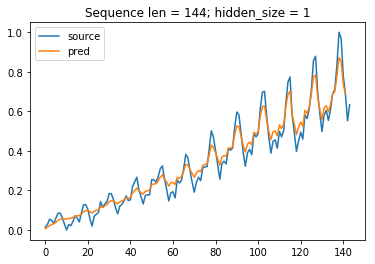

In [322]:
res = OutForLength(dataset, hidden_size=1)

Слишком маленький скрытый слой дал плохой результат, слишком большой - тоже (вероятно, т.к. функция попала в локальный минимум и не смогла глобально оптимизироваться). Размерность 5 дала наилучший результат.

2.Различные длины обучающей последовательности

 Epoch 528: mean loss 0.0026685849064961077
Sequence len = 30; hidden_size = 5
MSE = 0.05842661


e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


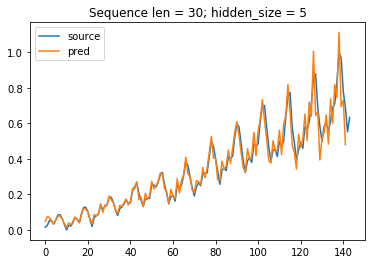

In [327]:
res = OutForLength(dataset, hidden_size=5, train_length=30)

 Epoch 421: mean loss 0.0030140934220980855
Sequence len = 15; hidden_size = 5
MSE = 0.056821235


e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


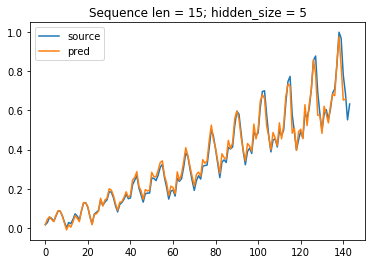

In [328]:
res = OutForLength(dataset, hidden_size=5, train_length=15)

 Epoch 629: mean loss 0.0031860165763646364
Sequence len = 50; hidden_size = 5
MSE = 0.05532064


e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


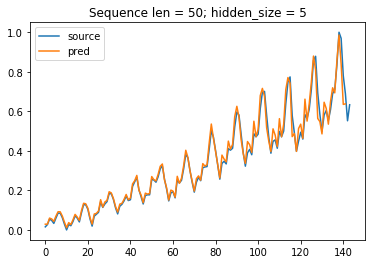

In [332]:
res = OutForLength(dataset, hidden_size=5, train_length=50)

 Epoch 288: mean loss 0.0037309963908197023
Sequence len = 5; hidden_size = 5
MSE = 0.11799834


e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


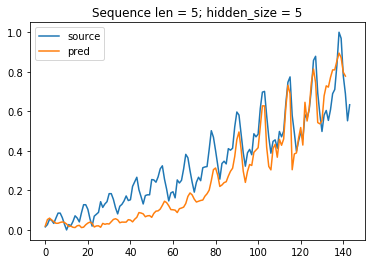

In [333]:
res = OutForLength(dataset, hidden_size=5, train_length=5)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: